# Export a Keras model to ONNX

In [2]:
from tensorflow import keras
import numpy as np

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [5]:
x_train = x_train / 255
x_test = x_test / 255

In [6]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [7]:
model = keras.Sequential()
model.add(keras.layers.Dense(256, input_shape = (784,)))
model.add(keras.layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203530 (795.04 KB)
Trainable params: 203530 (795.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = keras.optimizers.RMSprop(), 
    metrics = 'accuracy')

In [9]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size = 128,
    epochs = 12, 
    verbose = 1, 
    validation_split = 0.2)

Epoch 1/12
375/375 [==============================] - 1s 2ms/step - loss: 0.4044 - accuracy: 0.8837 - val_loss: 0.2906 - val_accuracy: 0.9198
Epoch 2/12
375/375 [==============================] - 1s 2ms/step - loss: 0.3087 - accuracy: 0.9129 - val_loss: 0.2955 - val_accuracy: 0.9154
Epoch 3/12
375/375 [==============================] - 1s 2ms/step - loss: 0.2955 - accuracy: 0.9166 - val_loss: 0.2978 - val_accuracy: 0.9137
Epoch 4/12
375/375 [==============================] - 1s 2ms/step - loss: 0.2886 - accuracy: 0.9179 - val_loss: 0.2758 - val_accuracy: 0.9244
Epoch 5/12
375/375 [==============================] - 1s 2ms/step - loss: 0.2830 - accuracy: 0.9214 - val_loss: 0.2856 - val_accuracy: 0.9226
Epoch 6/12
375/375 [==============================] - 1s 2ms/step - loss: 0.2792 - accuracy: 0.9215 - val_loss: 0.2684 - val_accuracy: 0.9292
Epoch 7/12
375/375 [==============================] - 1s 2ms/step - loss: 0.2752 - accuracy: 0.9224 - val_loss: 0.2839 - val_accuracy: 0.9227
Epoch 

In [25]:
import tf2onnx
import tensorflow as tf
import onnx

In [42]:
input_signature

[TensorSpec(shape=(None, 784), dtype=tf.float32, name='x')]

In [38]:
# Convert into ONNX format.

input_signature = [tf.TensorSpec((None, 784), tf.float32, name='x')]

onx, _ = tf2onnx.convert.from_keras(model, input_signature, opset = 13)

onnx.save(onx, "nn_history.onnx")

output_names = [n.name for n in onx.graph.output]

In [37]:
type(x_test)

numpy.ndarray

In [41]:
# Compute the prediction with onnxruntime.
import onnxruntime as rt

sess = rt.InferenceSession("nn_history.onnx", providers=["CPUExecutionProvider"])
pred_onx = sess.run(output_names, {input_name: x_test.astype(np.float32)})
score = tf.nn.softmax(pred_onx[0])
score

AttributeError: module 'numpy' has no attribute 'max'

# Export a PyTorch model to ONNX

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# export the model to onnx format

torch_model = MyModel()
torch_input = torch.randn(1, 1, 32, 32)
onnx_program = torch.onnx.dynamo_export(torch_model, torch_input)

/Users/cr/anaconda3/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


In [7]:
# save onnx model

onnx_program.save("my_image_classifier.onnx")

In [8]:
# load onnx model

import onnx
onnx_model = onnx.load("my_image_classifier.onnx")
onnx.checker.check_model(onnx_model)

In [12]:
# execute onnx model

import onnxruntime

onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")


Input length: 1
Sample input: (tensor([[[[-1.2810, -0.5377, -1.3351,  ..., -1.6985,  0.0440, -0.8516],
          [-0.6671, -0.7919,  0.2475,  ..., -1.3051,  0.8259, -0.5928],
          [-0.4290,  1.0490,  1.1059,  ...,  0.4758, -0.6152, -0.5365],
          ...,
          [-1.0012, -1.7745, -0.7147,  ...,  0.1330, -0.1598, -2.1911],
          [-0.1495, -1.0319, -0.5124,  ...,  0.9290,  0.0963,  0.1852],
          [ 0.3020, -0.8452, -1.1190,  ..., -0.8816,  1.2229,  1.6986]]]]),)


array([[-0.00667942, -0.07767168, -0.08462754,  0.15380469,  0.08587357,
         0.00499315,  0.03377185,  0.04003647,  0.0469114 , -0.02769783]],
      dtype=float32)

In [ ]:

ort_session = onnxruntime.InferenceSession("./my_image_classifier.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]
onnxruntime_outputs

## train a PyTorch model

In [28]:
# data and data loader

import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:02<00:00, 11014664.96it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2161638.63it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 9118033.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4041227.21it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


Ankle Boot  Trouser  T-shirt/top  Trouser


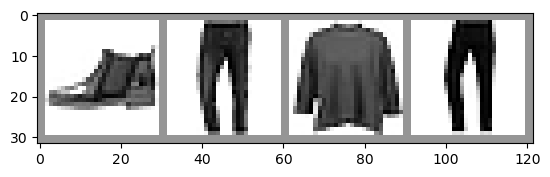

In [43]:
# data visualization 

import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [37]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [48]:
# export the model to onnx format

torch_input = torch.randn(1, 1, 32, 32)
onnx_program = torch.onnx.dynamo_export(model, torch_input)

# save onnx model
onnx_program.save("GarmentClassifier.onnx")

/Users/cr/anaconda3/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues

In [31]:
# loss function 

loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0367, 0.6377, 0.7771, 0.6670, 0.6913, 0.5162, 0.8693, 0.3734, 0.7938,
         0.6559],
        [0.0388, 0.5745, 0.7446, 0.4206, 0.4305, 0.5339, 0.5603, 0.5310, 0.3227,
         0.8697],
        [0.8478, 0.4371, 0.9015, 0.0819, 0.0720, 0.8004, 0.0334, 0.6342, 0.3093,
         0.1455],
        [0.9994, 0.7736, 0.1424, 0.3916, 0.8595, 0.9919, 0.7432, 0.8958, 0.4129,
         0.7520]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.355815887451172


In [34]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [35]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.6801093351989984
  batch 2000 loss: 0.8129357745582237
  batch 3000 loss: 0.771918094127439
  batch 4000 loss: 0.6599217872414738
  batch 5000 loss: 0.6213520293114707
  batch 6000 loss: 0.5866029818818206
  batch 7000 loss: 0.5350414350919891
  batch 8000 loss: 0.551953957606107
  batch 9000 loss: 0.5099398690465605
  batch 10000 loss: 0.4817820746870711
  batch 11000 loss: 0.5000084250310901
  batch 12000 loss: 0.45845551575301213
  batch 13000 loss: 0.4309469970709324
  batch 14000 loss: 0.4397816482865019
  batch 15000 loss: 0.41274120542476883
LOSS train 0.41274120542476883 valid 0.43800103664398193
EPOCH 2:
  batch 1000 loss: 0.3983981934916228
  batch 2000 loss: 0.3953496447806247
  batch 3000 loss: 0.3847016825609317
  batch 4000 loss: 0.3947581947962026
  batch 5000 loss: 0.3855391960152192
  batch 6000 loss: 0.3762464406257495
  batch 7000 loss: 0.3785832957803941
  batch 8000 loss: 0.3884009589564812
  batch 9000 loss: 0.35559115250228207
  batc

# Export a linear regression model to ONNX

In [ ]:
from sklearn.linear_model import LinearRegression
# train the data
iris = load_iris()
X, y = iris.data, iris.target
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)

# Convert into ONNX format.
from skl2onnx import to_onnx

onx = to_onnx(lr, X[:1])
with open("linrae_iris.onnx", "wb") as f:
    f.write(onx.SerializeToString())

# Export a random forest model to ONNX

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [6]:
# train the data
iris = load_iris()
X, y = iris.data, iris.target
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
# Convert into ONNX format.
from skl2onnx import to_onnx

onx = to_onnx(clr, X[:1])
with open("rf_iris.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [8]:
# Compute the prediction with onnxruntime.
import onnxruntime as rt

sess = rt.InferenceSession("rf_iris.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: X_test.astype(np.float32)})
pred_onx

[array([2, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1,
        2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2], dtype=int64)]

In [10]:
clr.predict(X_test)

array([2, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1,
       2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2])

In [12]:
y_test

array([2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1,
       2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2])

# Export tSNE model to ONNX

In [30]:
import inspect
import os
import numpy
import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from skl2onnx import update_registered_converter
import skl2onnx
from skl2onnx import convert_sklearn, get_model_alias
from skl2onnx.common._registration import get_shape_calculator
from skl2onnx.common.data_types import FloatTensorType


class PredictableTSNE(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        transformer=None,
        estimator=None,
        normalize=True,
        keep_tsne_outputs=False,
        **kwargs
    ):
        """
        :param transformer: `TSNE` by default
        :param estimator: `MLPRegressor` by default
        :param normalize: normalizes the outputs, centers and normalizes
            the output of the *t-SNE* and applies that same
            normalization to he prediction of the estimator
        :param keep_tsne_output: if True, keep raw outputs of
            *TSNE* is stored in member *tsne_outputs_*
        :param kwargs: sent to :meth:`set_params <mlinsights.mlmodel.
            tsne_transformer.PredictableTSNE.set_params>`, see its
            documentation to understand how to specify parameters
        """
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        if estimator is None:
            estimator = KNeighborsRegressor()
        if transformer is None:
            transformer = TSNE()
        self.estimator = estimator
        self.transformer = transformer
        self.keep_tsne_outputs = keep_tsne_outputs
        if not hasattr(transformer, "fit_transform"):
            raise AttributeError(
                "Transformer {} does not have a 'fit_transform' "
                "method.".format(type(transformer))
            )
        if not hasattr(estimator, "predict"):
            raise AttributeError(
                "Estimator {} does not have a 'predict' method.".format(type(estimator))
            )
        self.normalize = normalize
        if kwargs:
            self.set_params(**kwargs)

    def fit(self, X, y, sample_weight=None):
        """
        Runs a *k-means* on each class
        then trains a classifier on the
        extended set of features.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        y : numpy array of shape [n_samples, n_targets]
            Target values. Will be cast to X's dtype if necessary
        sample_weight : numpy array of shape [n_samples]
            Individual weights for each sample
        Returns
        -------
        self : returns an instance of self.
        Attributes
        ----------
        transformer_: trained transformeer
        estimator_: trained regressor
        tsne_outputs_: t-SNE outputs if *keep_tsne_outputs* is True
        mean_: average of the *t-SNE* output on each dimension
        inv_std_: inverse of the standard deviation of the *t-SNE*
            output on each dimension
        loss_: loss (*mean_squared_error*)
        between the predictions and the outputs of t-SNE
        """
        params = dict(y=y, sample_weight=sample_weight)

        self.transformer_ = clone(self.transformer)

        sig = inspect.signature(self.transformer.fit_transform)
        pars = {}
        for p in ["sample_weight", "y"]:
            if p in sig.parameters and p in params:
                pars[p] = params[p]
        target = self.transformer_.fit_transform(X, **pars)

        sig = inspect.signature(self.estimator.fit)
        if "sample_weight" in sig.parameters:
            self.estimator_ = clone(self.estimator).fit(
                X, target, sample_weight=sample_weight
            )
        else:
            self.estimator_ = clone(self.estimator).fit(X, target)
        mean = target.mean(axis=0)
        var = target.std(axis=0)
        self.mean_ = mean
        self.inv_std_ = 1.0 / var
        exp = (target - mean) * self.inv_std_
        got = (self.estimator_.predict(X) - mean) * self.inv_std_
        self.loss_ = mean_squared_error(exp, got)
        if self.keep_tsne_outputs:
            self.tsne_outputs_ = exp if self.normalize else target
        return self

    def transform(self, X):
        """
        Runs the predictions.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        Returns
        -------
        tranformed *X*
        """
        pred = self.estimator_.predict(X)
        if self.normalize:
            pred -= self.mean_
            pred *= self.inv_std_
        return pred

    def get_params(self, deep=True):
        """
        Returns the parameters for all the embedded objects.
        """
        res = {}
        for k, v in self.transformer.get_params().items():
            res["t_" + k] = v
        for k, v in self.estimator.get_params().items():
            res["e_" + k] = v
        return res

    def set_params(self, **values):
        """
        Sets the parameters before training.
        Every parameter prefixed by ``'e_'`` is an estimator
        parameter, every parameter prefixed by
        ``t_`` is for a transformer parameter.
        """
        pt, pe, pn = {}, {}, {}
        for k, v in values.items():
            if k.startswith("e_"):
                pe[k[2:]] = v
            elif k.startswith("t_"):
                pt[k[2:]] = v
            elif k.startswith("n_"):
                pn[k[2:]] = v
            else:
                raise ValueError("Unexpected parameter name '{0}'.".format(k))
        self.transformer.set_params(**pt)
        self.estimator.set_params(**pe)

array([<Axes: title={'center': 't-SNE embedding of the digits'}>,
       <Axes: >], dtype=object)

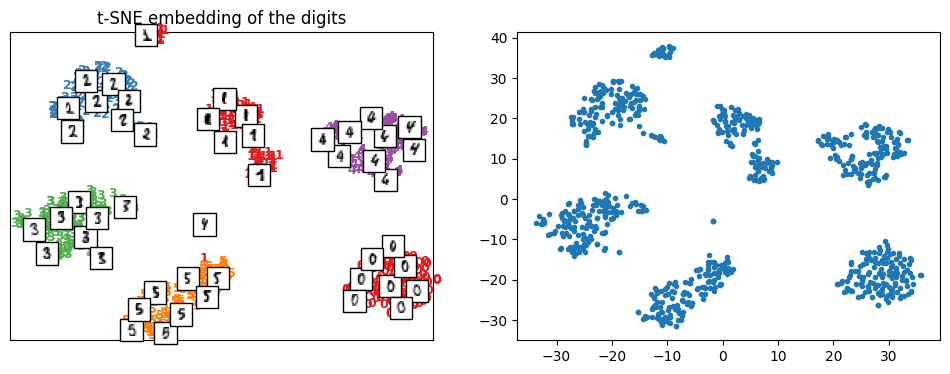

In [31]:
# fit the model

digits = datasets.load_digits(n_class=6)
Xd = digits.data
yd = digits.target
imgs = digits.images
n_samples, n_features = Xd.shape
n_samples, n_features

X_train, X_test, y_train, y_test, imgs_train, imgs_test = train_test_split(Xd, yd, imgs)

tsne = TSNE(n_components=2, init="pca", random_state=0)


def plot_embedding(Xp, y, imgs, title=None, figsize=(12, 4)):
    x_min, x_max = numpy.min(Xp, 0), numpy.max(Xp, 0)
    X = (Xp - x_min) / (x_max - x_min)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i in range(X.shape[0]):
        ax[0].text(
            X[i, 0],
            X[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        # only print thumbnails with matplotlib > 1.0
        shown_images = numpy.array([[1.0, 1.0]])  # just something big
        for i in range(X.shape[0]):
            dist = numpy.sum((X[i] - shown_images) ** 2, 1)
            if numpy.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = numpy.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r), X[i]
            )
            ax[0].add_artist(imagebox)
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[1].plot(Xp[:, 0], Xp[:, 1], ".")
    if title is not None:
        ax[0].set_title(title)
    return ax


X_train_tsne = tsne.fit_transform(X_train)
plot_embedding(X_train_tsne, y_train, imgs_train, "t-SNE embedding of the digits")

array([<Axes: title={'center': 'Predictable t-SNE of the digits\nStandardScaler+KNeighborsRegressor'}>,
       <Axes: >], dtype=object)

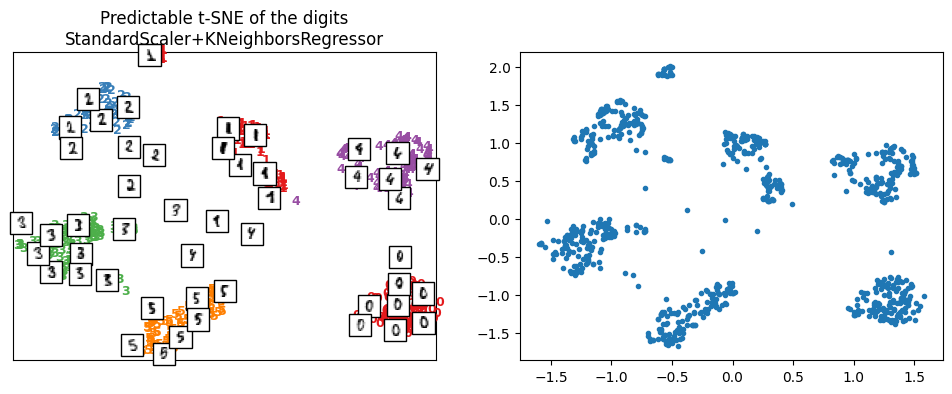

In [32]:
ptsne_knn = PredictableTSNE()
ptsne_knn.fit(X_train, y_train)

X_train_tsne2 = ptsne_knn.transform(X_train)
plot_embedding(
    X_train_tsne2,
    y_train,
    imgs_train,
    "Predictable t-SNE of the digits\n" "StandardScaler+KNeighborsRegressor",
)

array([<Axes: title={'center': 'Predictable t-SNE of the digits\nStandardScaler+KNeighborsRegressor'}>,
       <Axes: >], dtype=object)

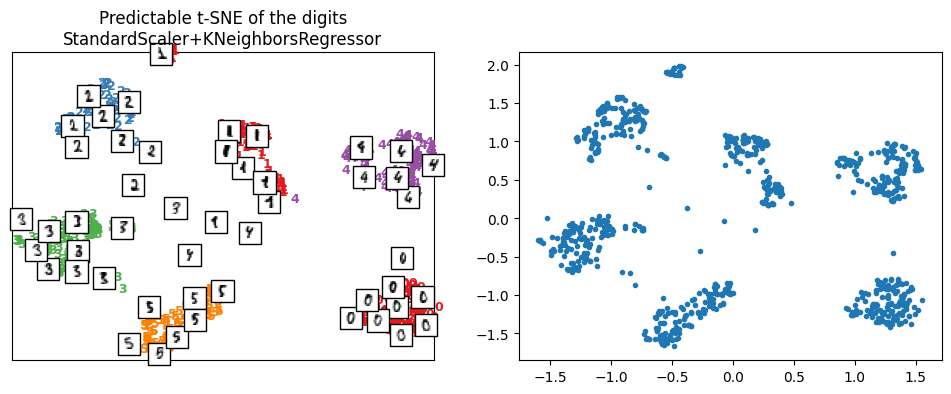

In [33]:
ptsne_knn = PredictableTSNE()
ptsne_knn.fit(X_train, y_train)

X_train_tsne2 = ptsne_knn.transform(X_train)
plot_embedding(
    X_train_tsne2,
    y_train,
    imgs_train,
    "Predictable t-SNE of the digits\n" "StandardScaler+KNeighborsRegressor",
)

array([<Axes: title={'center': 'Predictable t-SNE of the digits\nStandardScaler+KNeighborsRegressor'}>,
       <Axes: >], dtype=object)

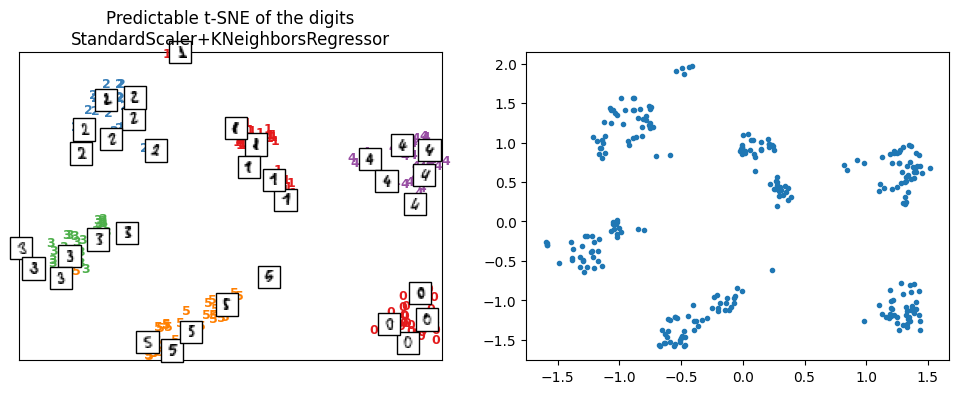

In [34]:
X_test_tsne2 = ptsne_knn.transform(X_test)
plot_embedding(
    X_test_tsne2,
    y_test,
    imgs_test,
    "Predictable t-SNE of the digits\n" "StandardScaler+KNeighborsRegressor",
)

In [38]:
ptsne_knn.inputs[0]

AttributeError: 'PredictableTSNE' object has no attribute 'inputs'

In [9]:
# onnx shape calculator

def predictable_tsne_shape_calculator(operator):
    input = operator.inputs[0]  # inputs in ONNX graph
    # output = operator.outputs[0]    # output in ONNX graph
    op = operator.raw_operator  # scikit-learn model (mmust be fitted)

    N = input.type.shape[0]  # number of observations
    C = op.estimator_._y.shape[1]  # dimension of outputs

    # new output definition
    operator.outputs[0].type = FloatTensorType([N, C])

In [10]:
# converter model

def predictable_tsne_converter(scope, operator, container):
    """
    :param scope: name space, where to keep node names, get unused new names
    :param operator: operator to converter, same object as sent to
        *predictable_tsne_shape_calculator*
    :param container: contains the ONNX graph
    """
    # input = operator.inputs[0]      # input in ONNX graph
    output = operator.outputs[0]  # output in ONNX graph
    op = operator.raw_operator  # scikit-learn model (mmust be fitted)

    # First step is the k nearest-neighbours,
    # we reuse existing converter and declare it as local
    # operator.
    model = op.estimator_
    alias = get_model_alias(type(model))
    knn_op = scope.declare_local_operator(alias, model)
    knn_op.inputs = operator.inputs

    # We add an intermediate outputs.
    knn_output = scope.declare_local_variable("knn_output", FloatTensorType())
    knn_op.outputs.append(knn_output)

    # We adjust the output of the submodel.
    shape_calc = get_shape_calculator(alias)
    shape_calc(knn_op)

    # We add the normalizer which needs a unique node name.
    name = scope.get_unique_operator_name("Scaler")

    # The parameter follows the specifications of ONNX
    # https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.Scaler
    attrs = dict(
        name=name,
        scale=op.inv_std_.ravel().astype(numpy.float32),
        offset=op.mean_.ravel().astype(numpy.float32),
    )

    # Let's finally add the scaler which connects the output
    # of the k-nearest neighbours model to output of the whole model
    # declared in ONNX graph
    container.add_node(
        "Scaler",
        [knn_output.onnx_name],
        [output.full_name],
        op_domain="ai.onnx.ml",
        **attrs
    )

In [11]:
update_registered_converter(
    PredictableTSNE,
    "CustomPredictableTSNE",
    predictable_tsne_shape_calculator,
    predictable_tsne_converter,
)

In [12]:
model_onnx = convert_sklearn(
    ptsne_knn,
    "predictable_tsne",
    [("input", FloatTensorType([None, X_test.shape[1]]))],
    target_opset=12,
)

# And save.
with open("predictable_tsne.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [13]:
print("ptsne_knn.tranform\n", ptsne_knn.transform(X_test[:2]))

ptsne_knn.tranform
 [[ 0.43371922 -1.7859755 ]
 [-0.99317044  1.3009655 ]]


In [14]:
sess = rt.InferenceSession("predictable_tsne.onnx", providers=["CPUExecutionProvider"])

pred_onx = sess.run(None, {"input": X_test[:1].astype(numpy.float32)})
print("transform", pred_onx[0])

transform [[ 0.43371922 -1.7859755 ]]


In [15]:
pred_onx = sess.run(None, {"input": X_test[1:2].astype(numpy.float32)})
print("transform", pred_onx[0])

transform [[-0.99317056  1.3009655 ]]


In [16]:
print("numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("onnx: ", onnx.__version__)
print("onnxruntime: ", rt.__version__)
print("skl2onnx: ", skl2onnx.__version__)

numpy: 1.26.4
scikit-learn: 1.4.2
onnx:  1.16.0
onnxruntime:  1.17.3
skl2onnx:  1.16.0


# Export a PCraster model to ONNX

In [24]:
os.chdir(r'/Users/cr/Documents/UU/Master/thesis/pcraster_demo_data-20131204/example/python_framework/deterministic')

In [25]:
from pcraster import *
from pcraster.framework import *

class RunoffModel(DynamicModel):
  def __init__(self, cloneMap):
    DynamicModel.__init__(self)
    setclone(cloneMap)

  def initial(self):
    # coverage of meteorological stations for the whole area
    self.rainZones = spreadzone("rainstat.map", scalar(0), scalar(1))

    # create an infiltration capacity map (mm/6 hours), based on the
    # soil map
    self.infiltrationCapacity = lookupscalar("infilcap.tbl", "soil.map")
    self.report(self.infiltrationCapacity, "infilcap")

    # generate the local drain direction map on basis of the elevation map
    self.ldd = lddcreate("dem.map", 1e31, 1e31, 1e31, 1e31)
    self.report(self.ldd, "ldd")

    # initialise timeoutput
    self.runoffTss = TimeoutputTimeseries("runoff", self, "samples.map", noHeader=False)

  def dynamic(self):
    # calculate and report maps with rainfall at each timestep (mm/6 hours)
    surfaceWater = timeinputscalar("rain.tss", self.rainZones)
    self.report(surfaceWater, "rainfall")

    # compute both runoff and actual infiltration
    runoff = accuthresholdflux(self.ldd, surfaceWater,\
         self.infiltrationCapacity)
    infiltration = accuthresholdstate(self.ldd, surfaceWater,\
         self.infiltrationCapacity)

    # output runoff, converted to m3/s, at each timestep
    logRunOff = runoff / scalar(216000)
    self.report(logRunOff, "logrunof")
    # sampling timeseries for given locations
    self.runoffTss.sample(logRunOff)

myModel = RunoffModel("mask.map")
dynModelFw = DynamicFramework(myModel, lastTimeStep=28, firstTimestep=1)
dynModelFw.run()

............................

0

In [26]:
# onnx shape calculator

def runoff_shape_calculator(operator):
    input = operator.inputs[0]  # inputs in ONNX graph
    # output = operator.outputs[0]    # output in ONNX graph
    op = operator.raw_operator  # scikit-learn model (mmust be fitted)

    N = input.type.shape[0]  # number of observations
    C = op.estimator_._y.shape[1]  # dimension of outputs

    # new output definition
    operator.outputs[0].type = FloatTensorType([N, C])

In [27]:
def runoff_converter(scope, operator, container):
    """
    :param scope: name space, where to keep node names, get unused new names
    :param operator: operator to converter, same object as sent to
        *predictable_tsne_shape_calculator*
    :param container: contains the ONNX graph
    """
    # input = operator.inputs[0]      # input in ONNX graph
    output = operator.outputs[0]  # output in ONNX graph
    op = operator.raw_operator  # scikit-learn model (mmust be fitted)

    # First step is the k nearest-neighbours,
    # we reuse existing converter and declare it as local
    # operator.
    model = op.estimator_
    alias = get_model_alias(type(model))
    runoff_op = scope.declare_local_operator(alias, model)
    runoff_op.inputs = operator.inputs

    # We add an intermediate outputs.
    runoff_output = scope.declare_local_variable("knn_output", FloatTensorType())
    runoff_op.outputs.append(runoff_output)

    # We adjust the output of the submodel.
    shape_calc = get_shape_calculator(alias)
    shape_calc(runoff_op)

    # We add the normalizer which needs a unique node name.
    name = scope.get_unique_operator_name("Scaler")

    # The parameter follows the specifications of ONNX
    # https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.Scaler
    attrs = dict(
        name=name,
        scale=op.inv_std_.ravel().astype(numpy.float32),
        offset=op.mean_.ravel().astype(numpy.float32),
    )

    # Let's finally add the scaler which connects the output
    # of the k-nearest neighbours model to output of the whole model
    # declared in ONNX graph
    container.add_node(
        "Scaler",
        [runoff_output.onnx_name],
        [output.full_name],
        op_domain="ai.onnx.ml",
        **attrs
    )

In [28]:
update_registered_converter(
    RunoffModel,
    "RunoffModel",
    runoff_shape_calculator,
    runoff_converter,
)

In [4]:
print(skl2onnx.supported_converters(from_sklearn=False))

['SklearnAdaBoostClassifier', 'SklearnAdaBoostRegressor', 'SklearnArrayFeatureExtractor', 'SklearnBaggingClassifier', 'SklearnBaggingRegressor', 'SklearnBayesianGaussianMixture', 'SklearnBayesianRidge', 'SklearnBernoulliNB', 'SklearnBinarizer', 'SklearnCalibratedClassifierCV', 'SklearnCast', 'SklearnCastRegressor', 'SklearnCastTransformer', 'SklearnCategoricalNB', 'SklearnClassLabels', 'SklearnColumnTransformer', 'SklearnComplementNB', 'SklearnConcat', 'SklearnCountVectorizer', 'SklearnDecisionTreeClassifier', 'SklearnDecisionTreeRegressor', 'SklearnDictVectorizer', 'SklearnExtraTreeClassifier', 'SklearnExtraTreeRegressor', 'SklearnExtraTreesClassifier', 'SklearnExtraTreesRegressor', 'SklearnFeatureHasher', 'SklearnFeatureUnion', 'SklearnFlatten', 'SklearnFunctionTransformer', 'SklearnGammaRegressor', 'SklearnGaussianMixture', 'SklearnGaussianNB', 'SklearnGaussianProcessClassifier', 'SklearnGaussianProcessRegressor', 'SklearnGaussianRandomProjection', 'SklearnGenericUnivariateSelect', 

In [29]:
model_onnx = convert_sklearn(
    RunoffModel,
    "runoff_model",
    [("input", FloatTensorType([None, X_test.shape[1]]))],
    target_opset=12,
)

# And save.
with open("runoff_model.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'type'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.
